# Load and analize data

In [1]:
# Import libraries
import pandas as pd 
import matplotlib.pyplot as plt
from Functions import *

Import the main dataframe

In [2]:
df = pd.read_csv('data.csv')

In [3]:
# Define topic names
ntopics = 10
topic_names = ['Politics BA Province', 'Economy/Dolar', 'Justice', 'Politics CL', '3rd Party', 'Wage/Inflation', 'Politics CR', 'Elections', 'Trash topic', 'Gossip & Sport']
# Define most shared media outlets:
main_outlets = df.groupby('outlet').count().sort_values(by='tid', ascending=False).reset_index()['outlet'][0:6].to_list()
main_outlets

['El Destape', 'Clarin', 'Infobae', 'La Nacion', 'Todo Noticias', 'Pagina 12']

We calculate the sentiment bias (SB) of  news

In [4]:
df['SB'] = df.apply(lambda row: SB_Albanese2020(row), axis = 1)

Dinamic model of votting: We choose the intention of votting as the label for each day 

# Calculate topic interest by partisan

## Topic interest by partisan

In [7]:
CR_topic_interests = df[df['dynamic_opinion'] == 'MP'][[f'T{i}' for i in range(8)]].sum() / df[df['dynamic_opinion'] == 'MP'][[f'T{i}' for i in range(8)]].sum().sum()
CL_topic_interests = df[df['dynamic_opinion'] == 'FF'][[f'T{i}' for i in range(8)]].sum() / df[df['dynamic_opinion'] == 'FF'][[f'T{i}' for i in range(8)]].sum().sum()

Topic interest minumun between Center - Left and Center - Right users (used to visualization in the follow plot)

In [8]:
minumun_topic_interest = [min(x,y) for x,y in zip(CL_topic_interests[:8],CR_topic_interests[:8])]

## Delta T: Topic interest difference by partisan

In [9]:
delta_T = [y-x for x,y in zip(CL_topic_interests[:8],CR_topic_interests[:8])]
index_by_deltaT = index_sorted_list(delta_T)
topic_names_sorted = [topic_names[i] for i in index_by_deltaT]

# Mean SB by Topic 

## Calculate mean SB by Topic 

In [12]:
df_unique_urls = df.drop_duplicates('url').copy()

In [19]:
df_unique_urls['most_representative_topic'] = df_urls_unique[[f'T{i}' for i in range(8)]].apply(lambda x: np.argmax(x), axis = 1)
topic_biases = df_unique_urls.groupby('most_representative_topic')['SB'].mean()

## Calculate mean SB by topic error

In [20]:
# Calculo el error del SB promedio por topico
quantiles99 = []
for topic in range(ntopics-2):
    
    data_sent_topic = df_unique_urls[df_unique_urls.most_representative_topic == topic].copy()
    sent_bootst = []
    for iteration in range(10000):
        sample = data_sent_topic.sample(n = data_sent_topic.shape[0], replace = True)
        sent_bootst.append(sample['SB'].mean())
        
    quantiles99.append(np.quantile(sent_bootst, q=[0.005, 0.995]))

# Plot Topic Analysis by partisan

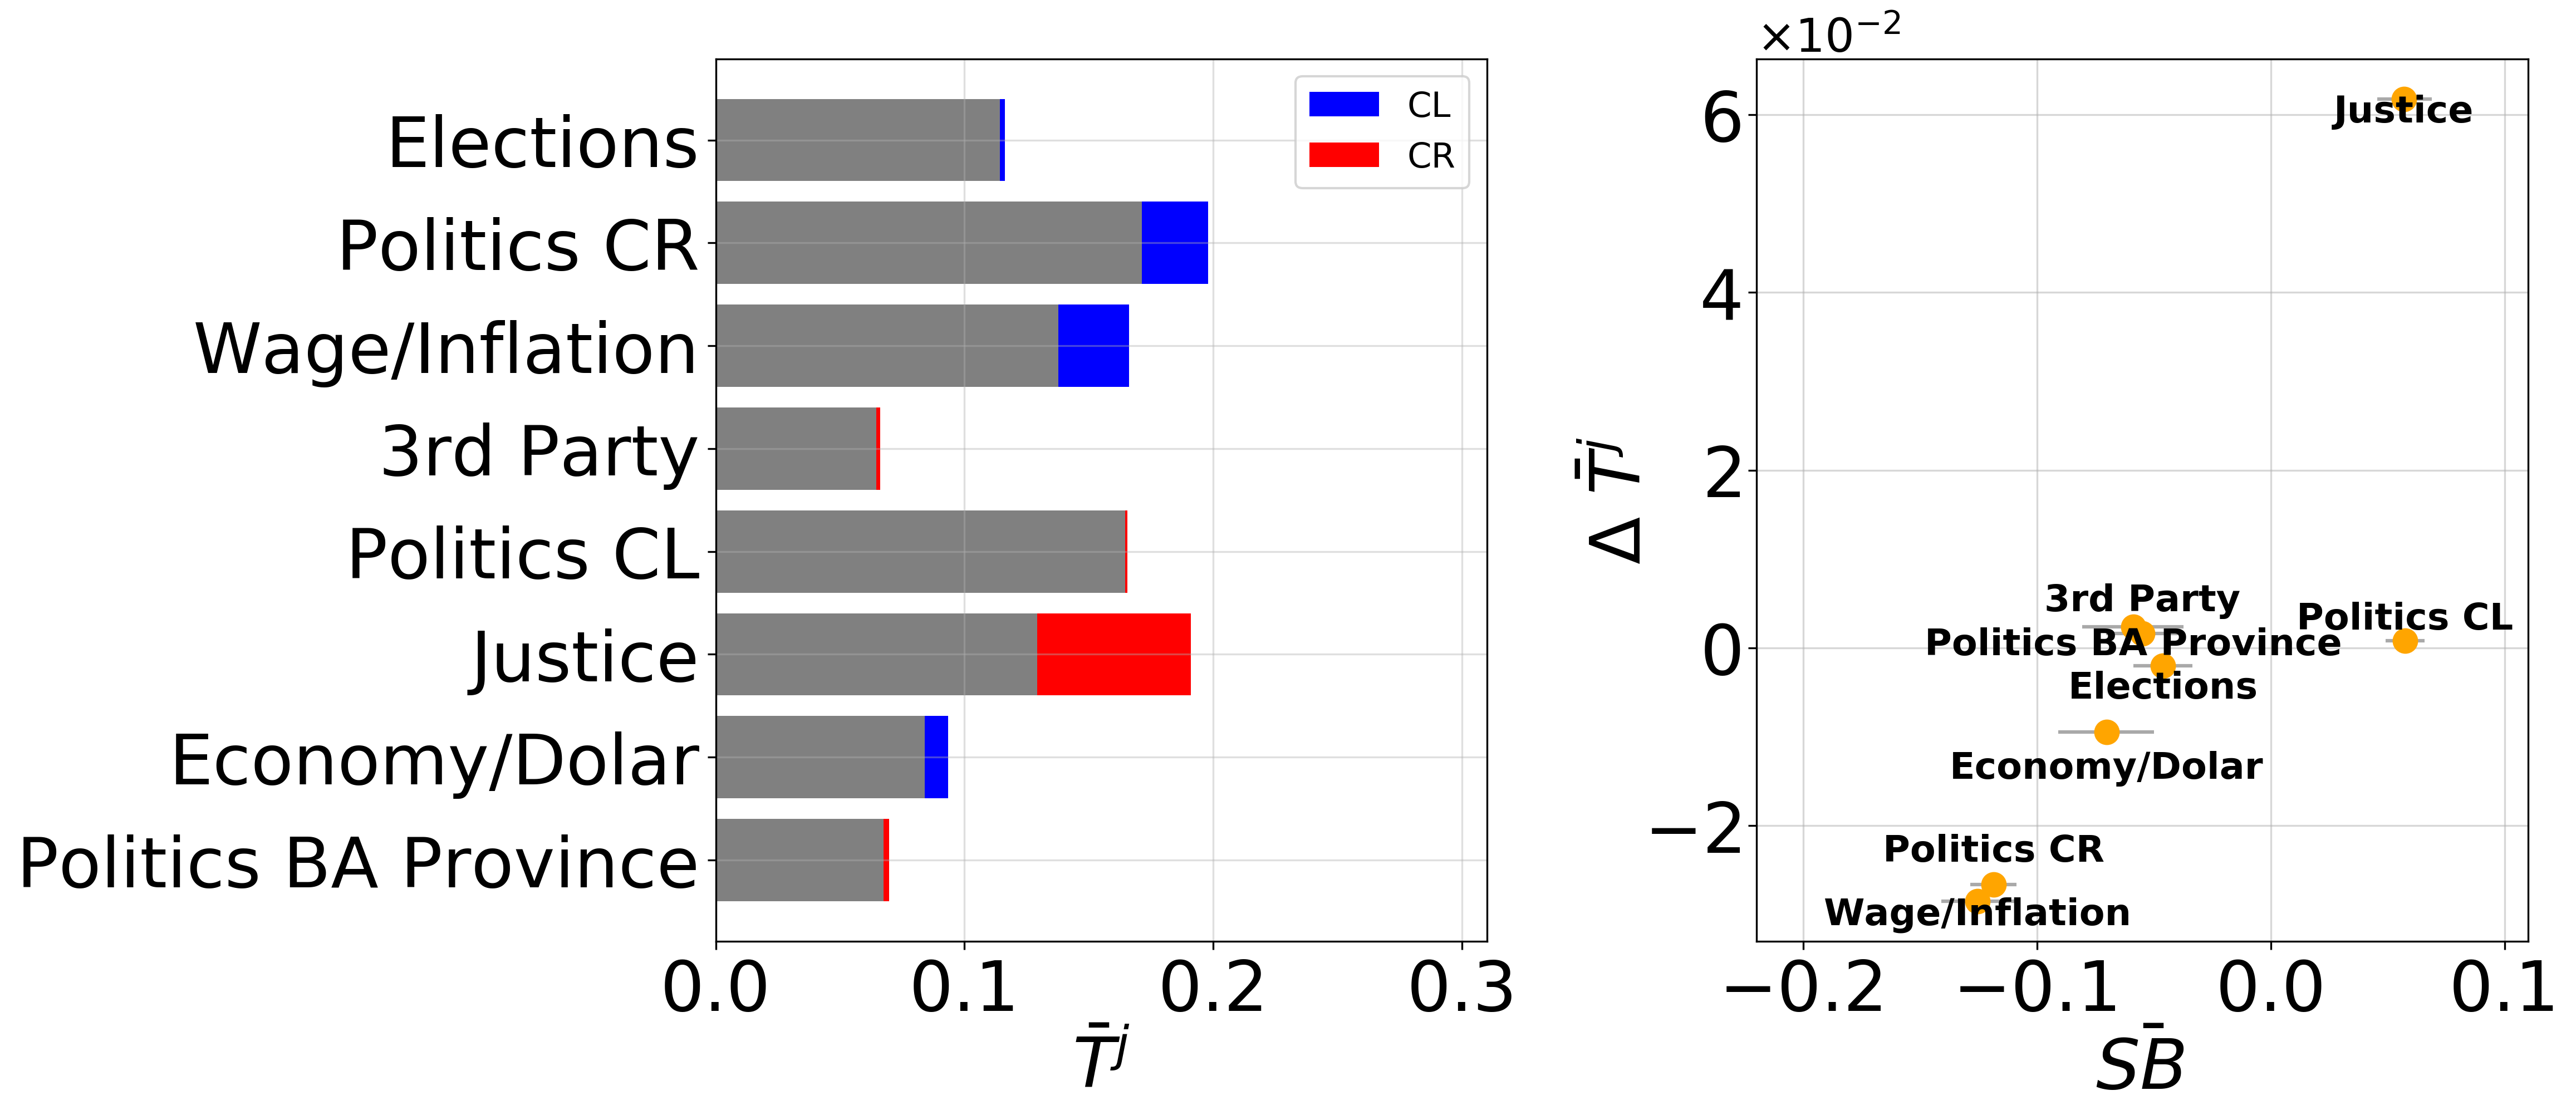

In [21]:
# Create the subplots
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7),dpi = 300)

# Plot on the first subplot
ax1.barh(range(ntopics-2), CL_topic_interests[:8], color = 'b', label = 'CL')
ax1.barh(range(ntopics-2), CR_topic_interests[:8], color = 'red', label = 'CR')
ax1.barh(range(ntopics-2), minumun_topic_interest, color = 'grey')
ax1.set_xticks(np.arange(0.00, 0.31, 0.1))
ax1.set_xlim([0,0.31])
ax1.set_yticks(range(ntopics-2))
ax1.set_yticklabels(topic_names[:8])

ax1.tick_params(axis='both', labelsize=30)
ax1.set_xlabel(r'$\bar{T}^j$', size = 30)
ax1.grid(alpha = 0.4)
ax1.legend(fontsize=15)

#indices = list(sesgo_por_mediof.index)

for i in range(len(topic_biases)):
    ax2.hlines(xmin=quantiles99[i][0], xmax=quantiles99[i][1],y = delta_T[i],  color = 'darkgray')

ax2.plot(topic_biases,delta_T,'o',color = 'orange',ms= 10,label = r'$\Delta$ $\bar{T}^j$ = $\bar{T}^j_{CR}$-$\bar{T}^j_{CL}$')
ax2.set_xlabel(r'$\bar{SB}$ ',fontsize = 30)
ax2.set_ylabel(r'$\Delta$ $\bar{T}^j$',fontsize = 30, labelpad=-5)
ax2.yaxis.get_offset_text().set_fontsize(20)  # Adjust the font size of the scientific notation
ax2.ticklabel_format(style="sci", axis="y", scilimits=(0,2), useMathText=True, useOffset=False) 
ax2.set_xticks([-0.2,-0.1,0,0.1])
ax2.grid(alpha = 0.5)
ax2.tick_params(axis='both', labelsize=30)
ax2.set_xlim([-0.22,0.11])
# zip joins x and y coordinates in pairs
distancesy = [10,-10,-14,10,-10,-12,-20,5]
for x,y,t,i in zip(topic_biases,delta_T,topic_names[0:8],index_by_deltaT):
    label = str(t)
    ax2.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,distancesy[i]), # distance from text to points (x,y)
                 ha='center',
                 weight='bold',
                 fontsize = 16)
fig.subplots_adjust(wspace=0.35)
plt.show()

In [22]:
from scipy import stats
stats.spearmanr(delta_T,topic_biases)

SpearmanrResult(correlation=0.7142857142857144, pvalue=0.04652823228416724)